# Experiments with the environment classes

A number of experiments for finding the right parametrization of the environments for the benchmarks. 

The code in this notebook contains a number of visualizations, __which only work in jupyter notebook__ not in vscode. 

In [2]:
# allow imports from the main source directory
import sys
sys.path.append('..')

import timeit
import time
import pathlib
import numpy as np
import random
import math
import shutil
from scipy import signal
import scipy
import matplotlib.pyplot as plt
from IPython.display import display, HTML
plt.rcParams['figure.figsize'] = (5,3)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams["animation.html"] = "jshtml" 

from Environment import EpidemicSpreadEnvironment, DissipationModelEnvironment, SoilMoistureEnvironment, PrecalculatedEnvironment, animate_environment
from Helper import shifted_add, create_gaussian_hump

import logging
logging.basicConfig(level=logging.WARNING)

# NOTE: The animation with the %matplotlib inline works with independent 
# jupyter notebook, but NOT when running the notebook from vscode
%matplotlib inline


# EpidemicSpreadEnvironment
Visualize the evolution of the epidemic spread environment in time in a video. Adjust the parametrization as appropriate to try out different settings.

In [3]:
print(int(math.sqrt(100) / 6) * 2 + 1)
print(int(math.sqrt(4000) / 6) * 2 + 1)

3
21


11


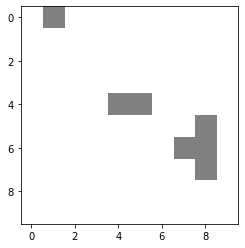

In [6]:
width = 10 # 1000
height = 10 # 2000
#spread_dimension = int(math.sqrt(width) / 6) * 2 + 3
spread_dimension = 11
print(spread_dimension)
infection_seeds = 3 * max(int(width / 30), 1)
p_transmission = 0.25
# seeds 1*, 0.15 looks good for ccr
# seeds 3*, 0.25 looks good for tylcv
env = EpidemicSpreadEnvironment("crop", width, height, seed=1, infection_duration = 5, 
                                p_transmission = p_transmission, spread_dimension=spread_dimension, 
                                infection_seeds = infection_seeds)
anim = animate_environment(env, frames=20, interval=200)
plt.show()
HTML(anim.to_html5_video())

# Soil moisture

In [ ]:
senv = SoilMoistureEnvironment("soil", 10, 10, seed=1, 
                               evaporation = 0.04, rainfall=0.06, rain_likelihood = 0.8)
# this only works in Jupyter notebook proper, not in vscode
anim = animate_environment(senv, frames=100, interval=100)
plt.show()
HTML(anim.to_html5_video())

In [ ]:
# experiment for Miniberry-10
seed = 3
for size in [10, 30, 100, 400]:
    senv = SoilMoistureEnvironment("soil", size, size, seed=seed, 
                                   evaporation = 0.04, rainfall=0.05, rain_likelihood = 0.8, warmup_time = 100)
    fig, (ax_0, ax_100) = plt.subplots(1,2)
    ax_0.imshow(senv.value, vmin=0, vmax=1, origin="lower", cmap="gray")
    for i in range(100):
        senv.proceed(1.0)
    ax_100.imshow(senv.value, vmin=0, vmax=1, origin="lower", cmap="gray")

## Testing the speed
Trying out different sizes of EpidemicSpreadEnvironment and DissipationModelEnvironment, and testing how long the creation and the proceed operation takes on them

In [ ]:
for i in [10, 50, 100, 200, 400, 1000, 2000, 4000]:
    env = EpidemicSpreadEnvironment("crop", i, i, seed=40, infection_duration = 5, p_transmission = 0.1)
    env.status[i // 2, i // 2] = 2
    env.status[(3*i) // 4, (3*i) // 4] = 5
    timeval = timeit.timeit("env.proceed(1.0)", number=1, globals=globals())
    print(f"map of size {i}x{i} a proceed took {timeval:0.2} seconds")
# trying out different sizes of DissipationModelEnvironment
print("DissipationModelEnvironment")
for i in [10, 50, 100, 200, 400, 1000, 2000, 4000]:
    env = DissipationModelEnvironment("pollution", i, i, seed=40)
    # env.status[i // 2, i // 2] = 2
    # env.status[(3*i) // 4, (3*i) // 4] = 5
    timeval = timeit.timeit("env.proceed(1.0)", number=1, globals=globals())
    print(f"map of size {i}x{i} a proceed took {timeval:0.2} seconds")

# PrecalculatedEnvironment
Testing that we can create a PrecalculatedEnvironment with an EpidemicSpreadEnvironment embedded, save it, load it back and visualize it.

In [ ]:
p = pathlib.Path.cwd().parent.parent.parent
#print(p)
savedir = pathlib.Path(p.parent, "__Temporary", p.name + "_data", "experiments")
#print(savedir)
savedir.mkdir(parents=True, exist_ok = True)
shutil.rmtree(savedir)
savedir.mkdir(parents=True, exist_ok = True)

height = 20 # was 2000
width = 20 # was 2000
env = EpidemicSpreadEnvironment("crop", width, height, seed=40, infection_duration = 5, p_transmission = 0.1)
env.status[width // 2, height // 2] = 2
env.status[(3*width) // 4, (3*height) // 4] = 5
precenv = PrecalculatedEnvironment(width,height, env, savedir)
for t in range(0, 100):
    precenv.proceed(1.0)

## reloading
pe = PrecalculatedEnvironment(width, height, None, savedir)
anim = animate_environment(pe)
plt.show()